# Q-learning with function approximation - egocentric environment

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/NiloufarRazmi/RL_Olfaction/HEAD?labpath=FuncApprox%2FFuncApprox_ego.ipynb)

## The task

<img src='./img/task.png' width="400">

## Initialization

In [1]:
# Import packages
import numpy as np
from tqdm import tqdm
import pandas as pd

In [2]:
# Load custom functions
from utils import Params
from environment_ego import (
    WrappedEnvironment,
    Actions,
    CONTEXTS_LABELS,
    LightCues,
    OdorID,
)
from agent import QLearningFuncApprox, EpsilonGreedy
import plotting

In [3]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Choose the task parameters

In [4]:
# Choose the parameters for the task
params = Params(epsilon=0.1, n_runs=3, numEpisodes=200, alpha=0.025)
params

Params(epsilon=0.1, gamma=0.8, alpha=0.025, jointRep=True, n_runs=3, numEpisodes=200)

## Load the environment and the agent algorithms

In [5]:
# Load the environment
env = WrappedEnvironment(params)

In [6]:
# Manually engineered features, optional
# if `None`, a diagonal matrix of features will be created automatically
features = np.matlib.repmat(
    np.eye(
        len(env.tiles_locations) * len(env.head_angle_space),
        len(env.tiles_locations) * len(env.head_angle_space),
    ),
    len(LightCues) * len(OdorID),
    len(LightCues) * len(OdorID),
)
features = None

In [7]:
# Load the agent algorithms
learner = QLearningFuncApprox(
    learning_rate=params.alpha,
    gamma=params.gamma,
    state_size=env.numStates,
    action_size=env.numActions,
    features_matrix=features,
)
explorer = EpsilonGreedy(epsilon=params.epsilon)

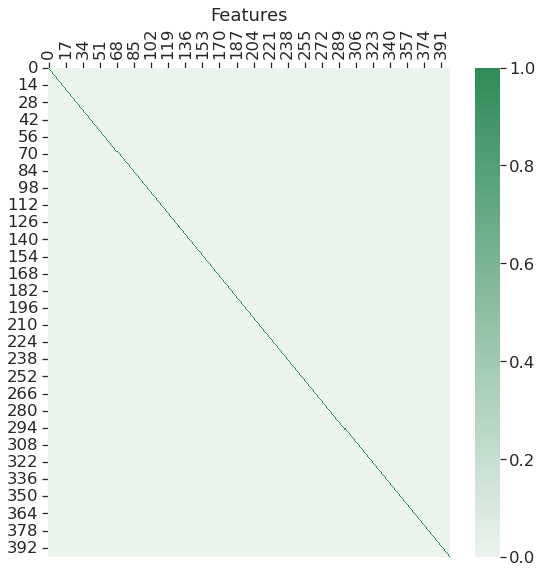

In [8]:
plotting.plot_heatmap(matrix=learner.features, title="Features")

## States and actions meaning

In [9]:
# # State space
# for idx, label in enumerate(CONTEXTS_LABELS):
#     plotting.plot_tiles_locations(
#         np.array(list(env.tiles_locations)) + idx * len(env.tiles_locations),
#         env.rows,
#         env.cols,
#         title=label,
#     )

### Correspondance between flat states and (internal) composite states

In [10]:
state = 63
env.convert_flat_state_to_composite(state)

{'location': 13, 'direction': 180, 'cue': <LightCues.North: 4>}

In [11]:
state = {"location": 13, "direction": 90, "cue": LightCues.North}
env.convert_composite_to_flat_state(state)

38

### Action meaning

In [12]:
action = 0
Actions(action)

<Actions.FORWARD: 0>

## Main loop

In [13]:
rewards = np.zeros((params.numEpisodes, params.n_runs))
steps = np.zeros((params.numEpisodes, params.n_runs))
episodes = np.arange(params.numEpisodes)
qtables = np.zeros((params.n_runs, *learner.Q_hat_table.shape))
all_states = []
all_actions = []

for run in range(params.n_runs):  # Run several times to account for stochasticity
    learner.reset_Q_hat_table()  # Reset the Q-table between runs

    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{params.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        step_count = 0
        done = False
        total_rewards = 0

        while not done:
            learner.Q_hat_table = learner.Q_hat(learner.weights, learner.features)

            action = explorer.choose_action(
                action_space=env.action_space,
                state=state,
                qtable=learner.Q_hat_table,
            )

            # Record states and actions
            all_states.append(state)
            all_actions.append(Actions(action).name)

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done = env.step(action, state)

            learner.weights[:, action] = learner.update_weights(
                state, action, reward, new_state
            )

            total_rewards += reward
            step_count += 1

            # Our new state is state
            state = new_state

        # explorer.epsilon = explorer.update_epsilon(episode)

        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count
    qtables[run, :, :] = learner.Q_hat_table

## Postprocessing

In [14]:
res = pd.DataFrame(
    data={
        "Episodes": np.tile(episodes, reps=params.n_runs),
        "Rewards": rewards.flatten(),
        "Steps": steps.flatten(),
    }
)
res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
# st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
qtable = qtables.mean(axis=0)  # Average the Q-table between runs

In [15]:
res

,Episodes,Rewards,Steps,cum_rewards
0,0,10.0,188.0,10.0
1,1,10.0,15.0,20.0
2,2,10.0,35.0,20.0
3,3,10.0,32.0,30.0
4,4,10.0,9.0,30.0
...,...,...,...,...
595,195,10.0,7.0,1810.0
596,196,10.0,8.0,1810.0
597,197,10.0,16.0,1820.0
598,198,10.0,11.0,1830.0


In [16]:
# plotting.qtable_directions_map(qtable, env.rows, env.cols)

## Visualization

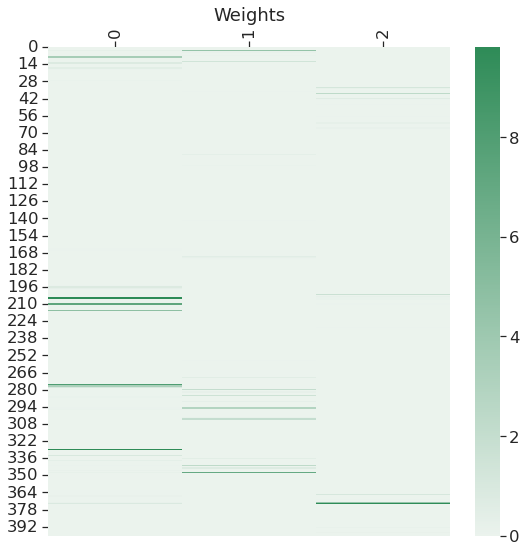

In [17]:
plotting.plot_heatmap(matrix=learner.weights, title="Weights")

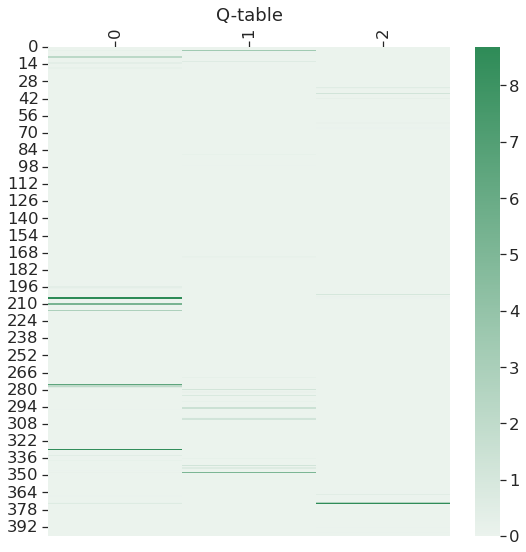

In [18]:
plotting.plot_heatmap(matrix=qtable, title="Q-table")

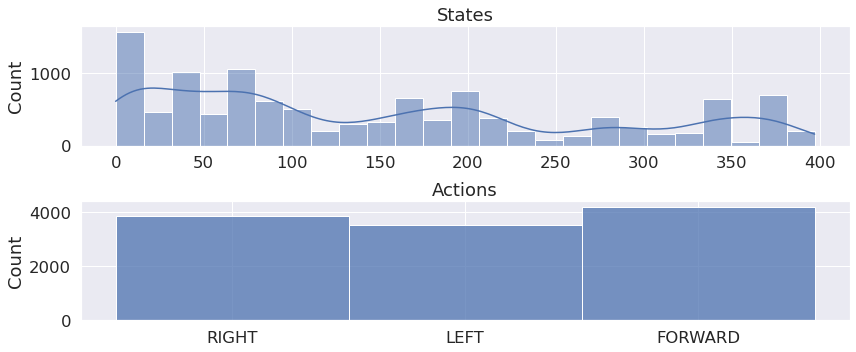

In [19]:
plotting.plot_states_actions_distribution(all_states, all_actions)

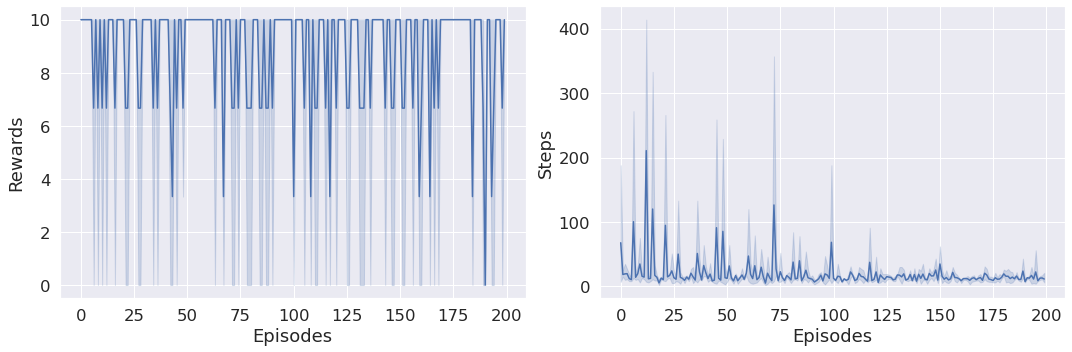

In [20]:
plotting.plot_steps_and_rewards(res)

In [21]:
def qtable_directions_map(qtable, rows, cols):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(rows, cols)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(rows, cols)
    directions = {0: "↑", 1: "↓", 2: "←", 3: "→"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(rows, cols)
    return qtable_val_max, qtable_directions

In [22]:
def arrow_right(x, y):
    x_tail = x - 0.25 * 0.75
    x_head = x + 0.25 * 0.75
    y_tail = y
    y_head = y
    res = pd.DataFrame(
        {
            "x_tail": [x_tail],
            "y_tail": [y_tail],
            "x_head": [x_head],
            "y_head": [y_head],
        }
    )
    return res


def arrow_down(x, y):
    x_tail = x
    x_head = x
    y_tail = y - 0.25 * 0.75
    y_head = y + 0.25 * 0.75
    res = pd.DataFrame(
        {
            "x_tail": [x_tail],
            "y_tail": [y_tail],
            "x_head": [x_head],
            "y_head": [y_head],
        }
    )
    return res


def arrow_up(x, y):
    x_tail = x
    x_head = x
    y_tail = y + 0.25 * 0.75
    y_head = y - 0.25 * 0.75
    res = pd.DataFrame(
        {
            "x_tail": [x_tail],
            "y_tail": [y_tail],
            "x_head": [x_head],
            "y_head": [y_head],
        }
    )
    return res


def arrow_left(x, y):
    x_tail = x + 0.25 * 0.75
    x_head = x - 0.25 * 0.75
    y_tail = y
    y_head = y
    res = pd.DataFrame(
        {
            "x_tail": [x_tail],
            "y_tail": [y_tail],
            "x_head": [x_head],
            "y_head": [y_head],
        }
    )
    return res

In [57]:
def draw_single_tile_arrows(row, col, arrows_directions, ax):
    coord_center_arrows = pd.DataFrame(
        {
            "x": [0.5 + col, 0.25 + col, 0.5 + col, 0.75 + col],
            "y": [0.25 + row, 0.5 + row, 0.75 + row, 0.5 + row],
        }
    )

    arrows_coords = pd.DataFrame(
        {"x_tail": [], "y_tail": [], "x_head": [], "y_head": []}
    )

    for angle_idx, direction in enumerate(arrows_directions):
        arrows_coords = pd.concat(
            [
                arrows_coords,
                direction(
                    coord_center_arrows.x[angle_idx],
                    coord_center_arrows.y[angle_idx],
                ),
            ],
            ignore_index=True,
        )

    for jdx, coord in arrows_coords.iterrows():
        arrow = mpatches.FancyArrowPatch(
            (coord.x_tail, coord.y_tail),
            (coord.x_head, coord.y_head),
            mutation_scale=10,
            color="green",
        )
        ax.add_patch(arrow)

In [58]:
from collections import OrderedDict

idx = 0
rows = env.rows
cols = env.cols
states = OrderedDict()
count = 0
for idx, cue in enumerate(env.cues):
    states[str(cue)] = OrderedDict()
    for jdx, angle in enumerate(env.head_angle_space):
        states[str(cue)][angle] = np.arange(
            (idx + jdx + count) * rows * cols,
            (idx + jdx + count + 1) * rows * cols,
        )
    count += jdx
states

OrderedDict([('OdorID.B',
              OrderedDict([(0,
                            array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
                                   17, 18, 19, 20, 21, 22, 23, 24])),
                           (90,
                            array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
                                   42, 43, 44, 45, 46, 47, 48, 49])),
                           (180,
                            array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
                                   67, 68, 69, 70, 71, 72, 73, 74])),
                           (270,
                            array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
                                   92, 93, 94, 95, 96, 97, 98, 99]))])),
             ('LightCues.South',
              OrderedDict([(0,
                            array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 1

In [59]:
from functools import partial


def map_action_to_direction(action, head_direction):
    arrow_directions = {
        "up": partial(arrow_up),
        "down": partial(arrow_down),
        "left": partial(arrow_left),
        "right": partial(arrow_right),
    }
    direction = None
    if head_direction == 0:
        if action == Actions.FORWARD:
            direction = arrow_directions["up"]
        elif action == Actions.RIGHT:
            direction = arrow_directions["right"]
        elif action == Actions.LEFT:
            direction = arrow_directions["left"]

    elif head_direction == 90:
        if action == Actions.FORWARD:
            direction = arrow_directions["right"]
        elif action == Actions.RIGHT:
            direction = arrow_directions["down"]
        elif action == Actions.LEFT:
            direction = arrow_directions["up"]

    elif head_direction == 180:
        if action == Actions.FORWARD:
            direction = arrow_directions["down"]
        elif action == Actions.RIGHT:
            direction = arrow_directions["left"]
        elif action == Actions.LEFT:
            direction = arrow_directions["right"]

    elif head_direction == 270:
        if action == Actions.FORWARD:
            direction = arrow_directions["left"]
        elif action == Actions.RIGHT:
            direction = arrow_directions["up"]
        elif action == Actions.LEFT:
            direction = arrow_directions["down"]

    if direction is None:
        raise ValueError("Impossible action-head direction combination")
    return direction

In [60]:
def qtable_directions_map_ego(qtable, rows, cols, states):
    """Get the best learned action & map it to directions for arrows."""
    q_val_best = OrderedDict()
    for cue in states:
        q_val_best[cue] = OrderedDict()
        for angle in states[cue]:
            q_val_best[cue][angle] = {}
            q_val_best[cue][angle]["q_max"] = (
                np.empty(qtable[states[cue][angle]].shape[0]) * np.nan
            )
            q_val_best[cue][angle]["best_action"] = []
            for st, flat_state in enumerate(states[cue][angle]):
                q_val_best[cue][angle]["q_max"][st] = qtable[flat_state, :].max()
                best_action = Actions(np.argmax(qtable[flat_state, :]))
                q_val_best[cue][angle]["best_action"].append(
                    map_action_to_direction(best_action, angle)
                )
    return q_val_best

In [61]:
from pprint import pprint

q_val_best = qtable_directions_map_ego(qtable, rows, cols, states)
# pprint(q_val_best)

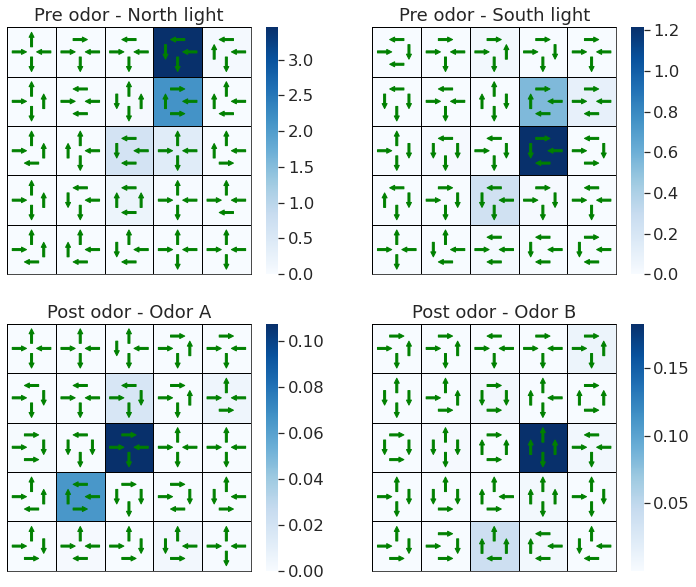

In [62]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


def plot_ego_q_values_maps(qtable, rows, cols, labels, q_val_best):
    """Plot the heatmap of the Q-values.

    Also plot the best action's direction with arrows."""

    f, ax = plt.subplots(2, 2, figsize=(12, 10))
    maps = [
        np.arange(0, rows * cols),
        np.arange(rows * cols, 2 * rows * cols),
        np.arange(2 * rows * cols, 3 * rows * cols),
        np.arange(3 * rows * cols, 4 * rows * cols),
    ]
    for idx, cue in enumerate(labels):
        qtable_val_max, qtable_directions = qtable_directions_map(
            qtable[maps[idx], :], rows, cols
        )
        sns.heatmap(
            qtable_val_max,
            # annot=qtable_directions,
            fmt="",
            ax=ax.flatten()[idx],
            cmap=sns.color_palette("Blues", as_cmap=True),
            linewidths=0.7,
            linecolor="black",
            xticklabels=[],
            yticklabels=[],
            annot_kws={"fontsize": "xx-large"},
        ).set(title=labels[cue])
        for _, spine in ax.flatten()[idx].spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.7)
            spine.set_color("black")

        for row in range(rows):
            for col in range(cols):
                arrows_directions = []
                for angle in q_val_best[cue]:
                    arrows_directions.append(
                        np.array(q_val_best[cue][angle]["best_action"]).reshape(
                            rows, cols
                        )[row, col]
                    )
                draw_single_tile_arrows(
                    row=row,
                    col=col,
                    arrows_directions=arrows_directions,
                    ax=ax.flatten()[idx],
                )

    plt.show()


plot_ego_q_values_maps(qtable, env.rows, env.cols, CONTEXTS_LABELS, q_val_best)